In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat,loadmat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')


print(device1)
print(device2)

ode_data = loadmat('Vanderpol_ODEsolver.mat')
t = ode_data['t']

# if device == 'cuda': 
#     print(torch.cuda.get_device_name())

cuda:2
cuda:3


In [2]:
level = "high"


#MATLAB Van Der Pol Example https://www.mathworks.com/help/matlab/ref/ode89.html
mu = 1
fo_val = 0.0

loss_thresh = 0.005

x = np.linspace(0,10,100).reshape(-1,1)


# y_true = true_1D_1(x_test)
# y_true_norm = np.linalg.norm(y_true,2)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

def colloc_pts(N_f,seed):
    #Collocation Points
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y)
    x01 = np.array([[0.0, 1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    
    x_coll_train = lb + (ub-lb)*sampling(N_f)
    x_coll_train = np.vstack((x_coll_train, bc1_x.reshape(-1,1))) # append training points to collocation points 

    return x_coll_train

def train_step(x_coll,f_hat):
    
    def closure1():
        optimizer.zero_grad()
        loss = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat) 
        loss = loss + PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat)
        loss.backward()
        
        return loss
    
#     def closure2():
#         optimizer.zero_grad()
#         loss = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat)
#         loss.backward()
        
#         return loss

    # optimizer.step(closure2)
    optimizer.step(closure1)

def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    x_coll = torch.from_numpy(colloc_pts(N_f,0)).float().to(device)
    f_hat = torch.zeros(x_coll.shape[0],1).to(device)
    
    loss_np1 = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    loss_np2 = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    
    # data_update(loss_np1)
    for i in range(max_iter):
        # x_coll = torch.from_numpy(colloc_pts(N_f,i*11)).float().to(device)
        # f_hat = torch.zeros(x_coll.shape[0],1).to(device)
        train_step(x_coll,f_hat)
        
        loss_np1 = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat).cpu().detach().numpy()
        loss_np2 = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat).cpu().detach().numpy()
            
        # data_update(loss_np1)
        # print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        print(i,"Loss1",loss_np1,"Loss2",loss_np2)
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [3]:

device = device1
from vanPol_model import Sequentialmodel_coPINN
label = "VPol_coPINN_"
bc1_x = x[0].reshape(-1,1)
bc1_y1 = np.array([2]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y1_bc1_train = torch.from_numpy(bc1_y1).float().to(device)
    

bc1_x = x[0].reshape(-1,1)
bc1_y2 = np.array([fo_val]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y2_bc1_train = torch.from_numpy(bc1_y2).float().to(device)    


x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)


max_reps = 1
max_iter = 200

N_f = 1000

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss =[]
    beta_val = []
    
    'Generate Training data'
    torch.manual_seed(reps*36)
     #Total number of collocation points 
    
    
    layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    # layers = np.array([1,50,50,50,50,1])
    PINN = Sequentialmodel_coPINN(layers,device)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 10, 
                              max_eval = 15, 
                              tolerance_grad = 1e-5, 
                              tolerance_change = 1e-5, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
   

    train_model(max_iter,reps)

    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)    
    
    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "beta": beta_full, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)


Sequentialmodel_coPINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-8): 8 x Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-8): 8 x Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Loss1 0.060991816 Loss2 0.29988474
1 Loss1 0.14229538 Loss2 0.12897347
2 Loss1 0.07043267 Loss2 0.15698047
3 Loss1 0.0434107 Loss2 0.16174334
4 Loss1 0.062165856 Loss2 0.13828078
5 Loss1 0.058636367 Loss2 0.13620228
6 Loss1 0.061222132 Loss2 0.12854761
7 Loss1 0.07095095 Loss2 0.115674235
8 Loss1 0.079131566 Loss2 0.104732305
9 Loss1 0.07734981 Loss2 0.10191389
10 Loss1 0.08182653 Loss2 0.09581991
11 Loss1 0.09430945 Loss2 0.08038281
12 Loss1 0.09631384 Loss2 0.07639059
13 Loss1 0.0953

In [6]:
x = np.linspace(0,10,100)
x_test = t.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device1)
# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

# layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
#     # layers = np.array([1,50,50,50,50,1])
# coPINN = Sequentialmodel_coPINN(layers)
# coPINN.to(device)
# coPINN.load_state_dict(torch.load('VPol_coPINN__0.pt', map_location=device))
# coPINN.eval()
y1_cP = PINN.forward1(x_test_tensor).cpu().detach().numpy()
# y1_cP = coPINN.test()
y2_cP = PINN.forward2(x_test_tensor).cpu().detach().numpy()



In [7]:
def train_step(x_coll,f_hat):
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat)
        loss.backward()
        
        return loss

    optimizer.step(closure)

    
def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    x_coll = torch.from_numpy(colloc_pts(N_f,0)).float().to(device)
    f_hat = torch.zeros(x_coll.shape[0],1).to(device)
    
    loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat).cpu().detach().numpy()
    data_update(loss_np)
    for i in range(max_iter):
        x_coll = torch.from_numpy(colloc_pts(N_f,i*11)).float().to(device)
        f_hat = torch.zeros(x_coll.shape[0],1).to(device)
        train_step(x_coll,f_hat)
        
        loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat).cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [8]:
device = device2
from vanPol_model import Sequentialmodel_vPINN

bc1_x = x[0].reshape(-1,1)
bc1_y = np.array([2]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y_bc1_train = torch.from_numpy(bc1_y).float().to(device)
    

bc2_x = x[0].reshape(-1,1)
x_bc2_train = torch.from_numpy(bc2_x).float().to(device)
bc2_val = torch.tensor(fo_val,device=device)
bc2_val = bc2_val.view(1,1)

x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)  


label = "VPol_vPINN_"
max_reps = 1
max_iter = 200

N_f = 1000

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss =[]
    beta_val = []
    
    'Generate Training data'
    torch.manual_seed(reps*36)
     #Total number of collocation points 
    
    
    # layers = np.array([1,50,50,50,50,50,50,50,50,50,2]) #9 hidden layers
    layers = np.array([1,100,100,100,100,100,100,2])
    # layers = np.array([1,50,50,50,50,2])
    PINN = Sequentialmodel_vPINN(layers,device)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 10, 
                              max_eval = 15, 
                              tolerance_grad = 1e-5, 
                              tolerance_change = 1e-5, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
   

    train_model(max_iter,reps)

    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)    
    
    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "beta": beta_full, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel_vPINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1-5): 5 x Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)
0
0 Train Loss 0.7726171 Test MSE 0 Test RE 0
1 Train Loss 0.72335297 Test MSE 0 Test RE 0
2 Train Loss 0.517167 Test MSE 0 Test RE 0
3 Train Loss 0.32135582 Test MSE 0 Test RE 0
4 Train Loss 0.28516543 Test MSE 0 Test RE 0
5 Train Loss 0.24674597 Test MSE 0 Test RE 0
6 Train Loss 0.24068189 Test MSE 0 Test RE 0
7 Train Loss 0.2243917 Test MSE 0 Test RE 0
8 Train Loss 0.21061128 Test MSE 0 Test RE 0
9 Train Loss 0.20473486 Test MSE 0 Test RE 0
10 Train Loss 0.20293051 Test MSE 0 Test RE 0
11 Train Loss 0.19917743 Test MSE 0 Test RE 0
12 Train Loss 0.19467425 Test MSE 0 Test RE 0
13 Train Loss 0.19287951 Test MSE 0 Test RE 0
14 Train Loss 0.19145344 Test MSE 0 Test RE 0
15 Train Loss 0.19087602 Tes

In [9]:
x_test = t
x_test_tensor = torch.from_numpy(x_test).float().to(device2)
layers = np.array([1,100,100,100,100,100,100,2])
# vPINN = Sequentialmodel_vPINN(layers)
# vPINN.to(device)
# vPINN.load_state_dict(torch.load('Vpol_vPINN_0.pt', map_location=device))

y = PINN.forward(x_test_tensor).cpu().detach().numpy()
y1_vP = y[:,0].reshape(-1,1)
y2_vP = y[:,1].reshape(-1,1)

In [10]:
x_test.shape

(161, 1)

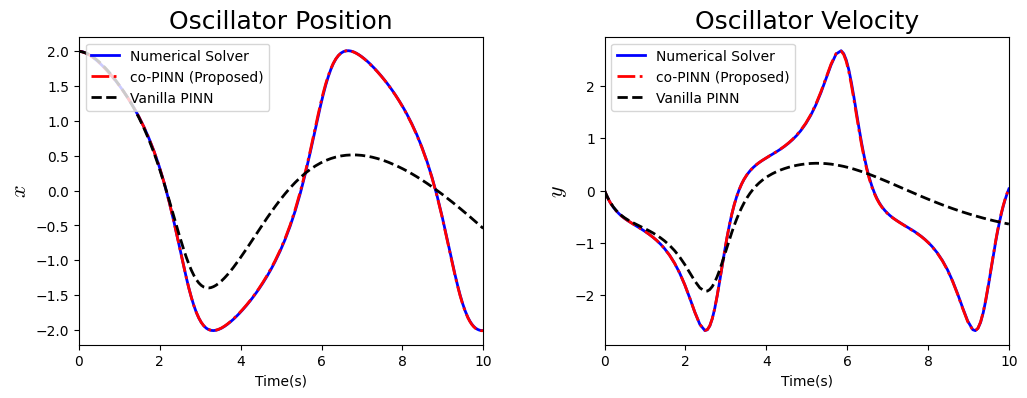

In [13]:
ode_data = loadmat('Vanderpol_ODEsolver.mat')
t = ode_data['t']
y1_true = ode_data['y'][:,0]
y2_true = ode_data['y'][:,1]

x = x_test

fig = plt.figure(figsize=(12, 4))

# fig,axs = plt.subplots(1,2)

ax = fig.add_subplot(1,2,1)
# ax = axs[0]

ax.plot(t,y1_true,'b',linewidth = 2,label = 'Numerical Solver')
ax.plot(x,y1_cP,'r-.',linewidth = 2,label = 'co-PINN (Proposed)')
ax.plot(x,y1_vP,'k--',linewidth = 2,label = 'Vanilla PINN')



ax.set_xlabel('Time(s)')
ax.set_ylabel('$x$',math_fontfamily = 'cm',fontsize = 16)
ax.set_title('Oscillator Position',fontsize = 18)
ax.legend(loc = 2)
# ax.set_aspect(aspect =2)
ax.set_xlim([0,10])

ax = fig.add_subplot(1,2,2)
# ax = axs[1]
ax.plot(t,y2_true,'b',linewidth = 2,label = 'Numerical Solver')
ax.plot(x,y2_cP,'r-.',linewidth = 2,label = 'co-PINN (Proposed)')
ax.plot(x,y2_vP,'k--',linewidth = 2,label = 'Vanilla PINN')


ax.set_xlabel('Time(s)')
ax.set_ylabel('$y$',math_fontfamily = 'cm',fontsize = 16)
ax.set_title('Oscillator Velocity',fontsize = 18)
ax.legend(loc = 2)
# ax.set_aspect(aspect =2)
ax.set_xlim([0,10])

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=-0.5)
# plt.figsize(10,10)
# plt.savefig('VanderPol_pred.pdf',format = 'pdf',bbox_inches = 'tight')
plt.savefig('VanderPol_pred.svg',format = 'svg',bbox_inches = 'tight')

In [ ]:
x_test = t.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)

In [ ]:
def RMSD(a,b):
    return np.sqrt(np.mean(np.square(a.reshape(-1,)-b.reshape(-1,))))

def corr(a,b):
    return np.corrcoef(a.reshape(-1,),b.reshape(-1,))[0,1]

print(RMSD(y2_cP,y2_true))
print(corr(y2_cP,y2_true))
print(RMSD(y2_vP,y2_true))
print(corr(y2_vP,y2_true))

0.0118558077631486
0.9999512489600981
0.7881093899013356
0.7873488162263108


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(PINN)

42002